# Here I compare the efficiency of functions

In [25]:
import numpy as np
import math
from scipy.integrate import RK45
import scipy.sparse as sparse
import timeit
import time
from numba import jit
import scipy.linalg as lin
import matplotlib.pyplot as plt
%load_ext Cython

Optimising

In [32]:
def sin(x): return np.sin(x)

def sin_opt(x): return np.sqrt(1-x**2)
x = np.random.rand(1000)

%timeit sin(x)
%timeit sin_opt(np.cos(x))

28.8 µs ± 319 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
37 µs ± 583 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


So, add in the sin optimisation ($\sin(x) = \sqrt{1-\cos^2(x)}$) isn't likely to help with much, it seems to slow down code.

Using Numba's parallel option

In [23]:
def RHS(t,zeta):
    # Set up
    N = int(len(zeta)/2)
    thetas, omegas = zeta[0:N], zeta[N:]
    first_theta = thetas[0]         # Used to calculate R and alpha
    deltas = np.roll(thetas,-1) - thetas  # We want to include all elements for when we create the matricies
    R = np.square(omegas)
    R[0] = R[0] + np.cos(first_theta)
    
    #Create matrix l_0:
    coses = -np.cos(deltas)
    coses_roll = np.roll(coses,+1)   # Have to roll so that the elements in the matrix are in the correct order
    two = 2*np.ones(N)               
    two[0] = 1    # Make the first and last element equal to 1
    L = sparse.csr_matrix(sparse.dia_matrix(([two,coses,coses_roll],[0,-1,1]),shape=(N,N)))
    
    # Solve for T
    T = sparse.linalg.spsolve(L,R)
    
    # Create matrix D_0:
    sines = np.sin(deltas)
    sines_roll = np.roll(sines,+1)   # Same reason as for l_0()
    D = sparse.dia_matrix(([-sines,sines_roll],[-1,+1]),shape=(N,N))
    
    # Solve for alphas
    alphas = D.dot(T)
    alphas[0] = alphas[0] - np.sin(first_theta)
    return np.concatenate((omegas,alphas))

@jit(parallel=True)
def RHS_jit(t,zeta):
    # Set up
    N = int(len(zeta)/2)
    thetas, omegas = zeta[0:N], zeta[N:]
    first_theta = thetas[0]        # Used to calculate R and alpha
    deltas = np.roll(thetas,-1) - thetas  # We want to include all elements for when we create the matricies
    R = np.square(omegas)
    R[0] = R[0] + np.cos(first_theta)
    
    #Create matrix l_0:
    coses = -np.cos(deltas)
    coses_roll = np.roll(coses,+1)   # Have to roll so that the elements in the matrix are in the correct order
    two = 2*np.ones(N)               
    two[0] = 1    # Make the first and last element equal to 1
    L = sparse.csr_matrix(sparse.dia_matrix(([two,coses,coses_roll],[0,-1,1]),shape=(N,N)))
    
    # Solve for T
    T = sparse.linalg.spsolve(L,R)
    
    # Create matrix D_0:
    sines = np.sin(deltas)
    sines_roll = np.roll(sines,+1)   # Same reason as for l_0()
    D = sparse.csr_matrix(sparse.dia_matrix(([-sines,sines_roll],[-1,+1]),shape=(N,N)))
    
    # Solve for alphas
    alphas = D.dot(T)
    alphas[0] = alphas[0] - np.sin(first_theta)
    return np.concatenate((omegas,alphas))

zeta = np.random.rand(10000)

RHS(0,zeta)
RHS_jit(0,zeta)

t1 = time.time()
for x in range(1000):
    RHS(0,zeta)
t2 = time.time() -t1
print(t2)
print('------')
t1 = time.time()
for x in range(1000):
    RHS_jit(0,zeta)
t2 = time.time() -t1bb
print(t2)

RuntimeError: The 'parallel' target is not currently supported on Windows operating systems when using Python 2.7, or on 32 bit hardware.

Not the most useful function.

In [2]:
b = np.random.rand((1000,1000))
a = np.random.rand(1000)
a2 = np.random.rand(500)
b2 = np.random.rand(500)
c = []

# S2 = np.sin(a)
# %timeit np.sin(a)
# %timeit np.cos(a)
# %timeit np.sqrt(1-np.square(S2))  #4x faster, but still need to consider the error that the method induces

%timeit np.cos(a)
%timeit math.cos(a)

# b[0,] = a
# print(b)

# t1 =time.time()
# for x in range(1000):
#     b[-1,] = a
#     b = np.zeros((1000,1000))
# t2 = time.time() -t1
# print(t2)


# t1 =time.time()
# for x in range(1000):
#     c.append(a)
#     c=[]
# t2 = time.time() -t1
# print(t2)

# %timeit sparse.csr_matrix(b)  # Quite slow, is it worth it?

# %timeit np.concatenate((thetas,thetas))  #Fastest
# %timeit np.hstack((thetas,thetas))       #Fast
# %timeit np.insert(np.zeros(1000),-1,a)
# %timeit np.insert(np.zeros(1000),0,a)
# %timeit np.insert(np.zeros(1000),1,a)

# %timeit b[0,] = a2
# %timeit b[0,] = a
                    
# %timeit np.zeros((1,1000))
# %timeit np.insert(a,-1,a2)
# %timeit np.insert(b,-1,b2)

# %timeit np.hstack(a)       # Same time
# %timeit np.vstack(a)

# %timeit b[1,] = a        # fastest 
# %timeit b[0,0:1000] = a  # Close second
# %timeit b[0:1000,0] = a  # 4 times slower

# %timeit a[0:1000,] 
# %timeit a[0,0:1000]

TypeError: 'tuple' object cannot be interpreted as an integer

Sparse matricies take a long time to create

In [39]:
b=np.random.rand(1000,1000)
%timeit sparse.csr_matrix(b)  # Quite slow, is it worth it?

56.3 ms ± 1.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


A bottleneck in the program, need to think of the problem in terms of arrays that make a matrix, instead of matricies, as the sparse matrices take a long time to build.

The most interesting numpy optimistision I found was:

In [36]:
a=1000
%timeit np.zeros((a,a))
%timeit np.empty((a,a))

11.9 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.7 ms ± 99.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Almost a 1000x speedup. However, it must be used with caution, as np.empty creates an uninitalised array, which can cause problems when acessing the array.

See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.empty.html

In [128]:
# %timeit np.arange(20)[0:5]
# %timeit np.arange(20)[:5]

# %timeit np.power(np.arange(100),2)
# %timeit np.square(np.arange(100))    #Bit faster

deltas = a
N = len(a)-1

sines = np.sin(deltas)
sines_roll = np.roll(sines,+1)   # Same reason as for l_0()
%timeit sparse.dia_matrix([-sines,sines_roll],[-1,+1],shape=(N,N),format="csr")
%timeit sparse.csr_matrix(sparse.dia_matrix(([-sines,sines_roll],[-1,+1]),shape=(N,N)))

TypeError: __init__() got multiple values for argument 'shape'

Plot the speed of execution of functions with respect to the length of the input array

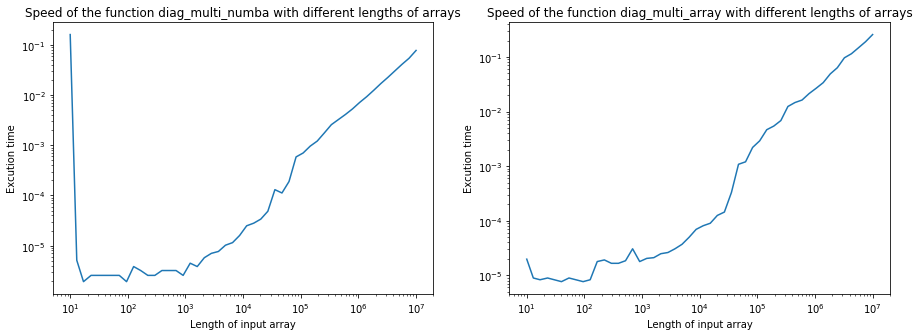

In [21]:
a = 1000000

# print(np.zeros_like((a,a)))
# print(np.zeros((a,a)))

# %timeit np.zeros((a))
# %timeit np.zeros_like((a))

# Only after 10,000 elements do we see a difference between zeros and zeros_like, same is true for 2d cases

# Matrix of diagonal multiplication is faster with for loops

def roll_1(vect): 
    return np.concatenate((np.array([vect[-1]]),vect[0:len(vect)-1]))

def roll_0(vect): 
    return np.concatenate((np.array([0]),vect[0:len(vect)-1]))

@jit
def roll_minus_1(vect): 
    # Import a np array and roll the array by -one number
    return np.concatenate((vect[1:],np.array([vect[0]])))

def diag_multi(x,y,a):
    N = len(a)
    L = sparse.dia_matrix(([x,roll_1(y)],[-1,+1]),shape=(N,N))
    return L.dot(a)

@jit(nopython=True,cache=True)
def diag_multi_array_numba(x,y,a):
    N = len(a)  # number of pendulums
    z = np.zeros(N)
    z1 = np.zeros(N)
    
    z[1:N] = -x[0:N-1]*a[0:N-1]
    z1[0:N-1] = y[0:N-1]*a[1:N]
    return z + z1

@jit(nopython=True,cache=True)
def diag_multi_numba(x,y,a):
    # About 40x faster than creating diagonal matrix and dotting. See Optimising.ipnb
    N = len(a)
    z = np.zeros(N)
    
    for n in range(1,N-1):
        z[n] = (x[n-1]*a[n-1] + y[n]*a[n+1])
    z[0] = y[0]*a[1]
    z[N-1] = x[N-2]*a[N-2]
    return z

def diag_multi_array(x,y,a):
    N = len(a)  # number of pendulums
    z = np.zeros(N)
    z1 = np.zeros(N)
    
    z[1:N] = x[0:N-1]*a[0:N-1]
    z1[0:N-1] = y[0:N-1]*a[1:N]
    return z1 - z

# Computes the time taken for a function for different input values 'space' and prints to a  list
def optimiser(space, fun):
    times = []
    for a in space:
        x = np.random.rand(a)
        y = np.random.rand(a)
        n = np.random.rand(a)

        t1=-time.clock()
        fun(x,y,n)
        t1 += time.clock()
        times.append(t1)
    return times

space = np.logspace(1,7,50,dtype=np.int32)

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].loglog(space,optimiser(space,diag_multi_numba))
ax[0].set_title('Speed of the function diag_multi_numba with different lengths of arrays')
ax[0].set_xlabel('Length of input array')
ax[0].set_ylabel('Excution time')

ax[1].loglog(space,optimiser(space,diag_multi_array))
ax[1].set_title('Speed of the function diag_multi_array with different lengths of arrays')
ax[1].set_xlabel('Length of input array')
ax[1].set_ylabel('Excution time')
plt.show()

#%timeit diag_multi(x,y,n)  This is super slow, don't use. Almost half the time is taken forming the diagonal matrix
# %timeit diag_multi_array(x,y,n)
# %timeit diag_multi_array_numba(x,y,n)
# %timeit diag_multi_numba(x,y,n)

The above plots were done to compare the implematation of the matrix multiplication of $D \bullet T$ in Numpy and Numba. We can see that they are both very similar in excution time, apart from the large spike at the beginning of the left hand figure. This is likely due to the inital compliation of the function. However, it should be noted that these results were obtained on a windows distribution of standard python and be boosted by excution on a Linux computer, with Intel's Python, where a fully supported version of all of Numpy's features could be used.

64 bit Numpy does not work on windows.
https://docs.scipy.org/doc/numpy-1.14.0/release.html#experimental-windows-64-bits-support

In [17]:
a = np.arange(10)

len(a[1:10])

9

# Numpy isn't always faster

In [20]:
@jit(nopython=True,cache=True)
def roll_minus_1(vect): 
    # Import a np array and roll the array by -one number
    return np.concatenate((vect[1:],np.array([vect[0]])))

x = 10000
roll_minus_1(np.random.rand(x))

%timeit np.roll(np.random.rand(x),-1)   #slower
%timeit roll_minus_1(np.random.rand(x)) #4x faster

31.8 µs ± 1.44 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
18.3 µs ± 2.73 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


# Cythonising

In [26]:
%%cython 
# The cyhonised code of loop. The %%cython has to be at the top of the cell.

import numpy as np
cimport numpy as np

DTYPE = np.int64
ctypedef np.int_t DTYPE_t

cpdef loop_cython(int a):
    cdef int n = 0
    cdef int n_max = a
    cdef int iteration = 0
    cdef int total = 0
    cdef np.ndarray rand = np.empty(a, dtype=DTYPE)
    while n<n_max:
        total += n
        rand*rand
        n += 1
        iteration += 1
    return

CompileError: command 'C:\\Program Files (x86)\\Microsoft Visual Studio\\2017\\BuildTools\\VC\\Tools\\MSVC\\14.14.26428\\bin\\HostX86\\x86\\cl.exe' failed with exit status 2

In [ ]:
# Pure python function
def loop(a):
    n = 0
    n_max = a
    iteration = 0
    total = 0
    while n<n_max:
        total += n
        np.random.rand(a)*np.random.rand(a)
        n += 1
        iteration += 1
    return

In [ ]:
%timeit loop_cython(1000)
%timeit loop(1000)

Wow, a 10x speed up. Here we can see that cythonising the loop will possible lead to great speedups.

So, let's try... Here is the original version of the loop:

In [28]:
def main_loop(zeta, t_in, t_step,t_max, n_step, N, atol, pre_steps):
    thetas  = np.zeros((n_step,N))
    omegas  = np.zeros((n_step,N))
    theta   = np.zeros(N)
    omega   = np.zeros(N) 
    xvals   = np.zeros((n_step,N))
    yvals   = np.zeros((n_step,N))
    KE_vals = np.zeros((n_step,N))
    KE_tot  = np.zeros(n_step)
    speeds  = np.zeros((n_step,N))
    global status  
    status  = []
    
    t = int(t_in)
    iteration = int(0)
    # Initalise the Runge-Kutta function
    integrate = RK45(RHS, t_in, zeta, t_max, max_step=t_step, atol = atol)
    
    # Integrate before
    for n in range(pre_steps):
        integrate.step()
    
    t1 = time.time()
    while iteration < n_step:
        zeta = integrate.y                    # Call current state
        theta = zeta[0:N]                     # Slice to get the thetas, consider storing as a list of numpy arrays, they seem to faster (see Optiming.ipnb)
        thetas[iteration,] = theta

        omega = zeta[N:]
        omegas[iteration,]  = omega

        KE_vals[iteration,], KE_tot[iteration], speeds[iteration,], xvals[iteration,], yvals[iteration,] = important_vals(theta,omega,N)
        status.append(integrate.step())                                 # Integrate
        iteration = iteration + 1
    t2 = time.time()
    return thetas, omegas, xvals, yvals, KE_vals,KE_tot,speeds

Here is the Cythonised version

In [ ]:
%%cython 
# The cyhonised code of loop. The %%cython has to be at the top of the cell.

from scipy.integrate import RK45
import numpy as np
import time
cimport numpy as np

cimport cython

DTYPE = np.int64
ctypedef np.int_t DTYPE_t

def main_loop_cython(zeta, t_in, t_step,t_max, n_step, N, atol, pre_steps):
    thetas  = np.zeros((n_step,N))
    omegas  = np.zeros((n_step,N))
    theta   = np.zeros(N)
    omega   = np.zeros(N) 
    xvals   = np.zeros((n_step,N))
    yvals   = np.zeros((n_step,N))
    KE_vals = np.zeros((n_step,N))
    KE_tot  = np.zeros(n_step)
    speeds  = np.zeros((n_step,N))
    global status  
    status  = []
    
    t = int(t_in)
    iteration = int(0)
    # Initalise the Runge-Kutta function
    integrate = RK45(RHS, t_in, zeta, t_max, max_step=t_step, atol = atol)
    
    # Integrate before steping
    for n in range(pre_steps):
        integrate.step()
    
    t1 = time.time()
    while iteration < n_step:
        zeta = integrate.y                    # Call current state
        theta = zeta[0:N]                     # Slice to get the thetas, consider storing as a list of numpy arrays, they seem to faster (see Optiming.ipnb)
        thetas[iteration,] = theta

        omega = zeta[N:]
        omegas[iteration,]  = omega

        KE_vals[iteration,], KE_tot[iteration], speeds[iteration,], xvals[iteration,], yvals[iteration,] = important_vals(theta,omega,N)
        status.append(integrate.step())                                 # Integrate
        iteration = iteration + 1
    t2 = time.time()
    return thetas, omegas, xvals, yvals, KE_vals,KE_tot,speeds

O crap, I ran out of time and wasn't able to get it to work. But, if I do ever get it working, then I'll be sure to send it to you.

In [ ]:
N=1000
%timeit main_loop(np.random.rand(2*N), 0, np.inf,np.inf, 600, N, 1e-16, 0)
%timeit main_loop_cython(np.random.rand(2*N), 0, np.inf,np.inf, 600, N, 1e-16, 0)